# Using Convolutions with LSTMs

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [30]:
def plot_series(time,series,format='-',start=0,end=None,title=None,xlabel=None,ylabel=None,legend=None):
    plt.figure(figsize=(10,6))
    if type(series) is tuple:
        for series_number in series:
            plt.plot(time[start:end],series_number[start:end],format)
    else:
        plt.plot(time[start:end],series[start:end])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

In [6]:
def trend(time,slope=0):
    series=slope*time
    return series
def seasonal_pattern(season_time):
    data_pattern=np.where(season_time<0.4,np.cos(season_time*2*np.pi),1/np.exp(3*season_time))
    return data_pattern
def seasonality(time,period,amplitude=1,phase=0):
    season_time=((time+phase)%period)/period
    data_pattern=amplitude*seasonal_pattern(season_time)
    return data_pattern

def noise(time,noise_level=1,seed=None):
    rnd=np.random.RandomState(seed)
    noise=rnd.randn(len(time))*noise_level
    return noise

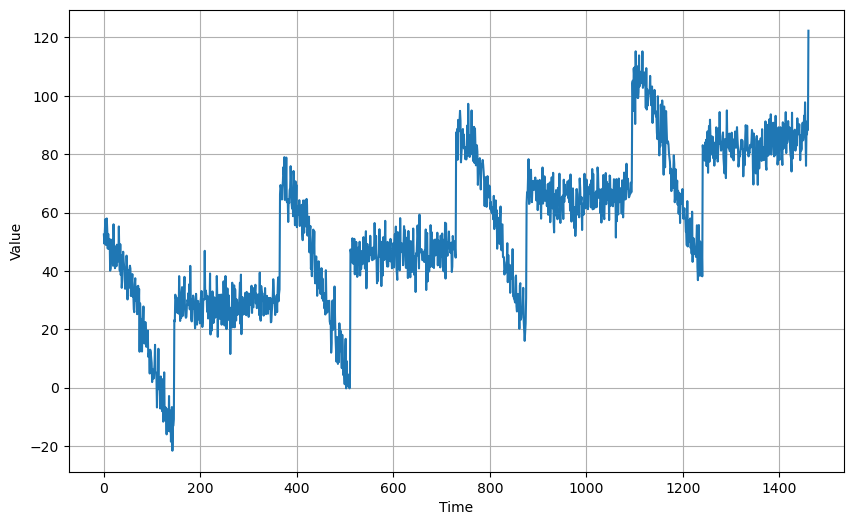

In [7]:
time=np.arange(4*365+1,dtype='float32')
baseline=10
amplitude=40
slope=0.05
noise_level=5

series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
series+=noise(time,noise_level,seed=42)
plot_series(time,series,xlabel='Time',ylabel='Value')

In [8]:
split_time=1000
time_train=time[:split_time]
x_train=series[:split_time]
time_valid=time[split_time:]
x_valid=series[split_time:]

In [9]:
window_size=20
batch_size=16
shuffle_buffer_size=1000

In [10]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset=dataset.flat_map(lambda window:window.batch(window_size+1))
    dataset=dataset.map(lambda window:(window[:-1],window[-1]))
    dataset=dataset.shuffle(shuffle_buffer)
    dataset=dataset.batch(batch_size).prefetch(1)
    return dataset

In [11]:
train_set=windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

In [14]:
tf.keras.backend.clear_session()
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64,kernel_size=3,strides=1,padding='causal',activation='relu',input_shape=[window_size,1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x:x*400)

    
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


# tuning the learning rate

In [15]:
init_weights=model.get_weights()

In [17]:
lr_scheduler=tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10**(epoch/20)
)
optimizer=tf.keras.optimizers.SGD(momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer)
history=model.fit(train_set,epochs=100,callbacks=[lr_scheduler])

Epoch 1/100
62/62 [==============================] - 11s 10ms/step - loss: 11.5957 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 1s 8ms/step - loss: 9.7585 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 1s 7ms/step - loss: 8.5816 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 1s 8ms/step - loss: 7.8651 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 1s 8ms/step - loss: 7.4401 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 1s 7ms/step - loss: 7.2066 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 1s 8ms/step - loss: 7.0367 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 1s 7ms/step - loss: 6.8802 - lr: 2.2387e-08
Epoch 9/100
62/62 [==============================] - 1s 8ms/step - loss: 6.7266 - lr: 2.5119e-08
Epoch 10/100
62/62 [==============================] - 1s 10ms/step - loss: 6.5815 - lr: 2.8184e-08
Epoch 11/100
62/62 [=====

(1e-08, 0.001, 0.0, 50.0)

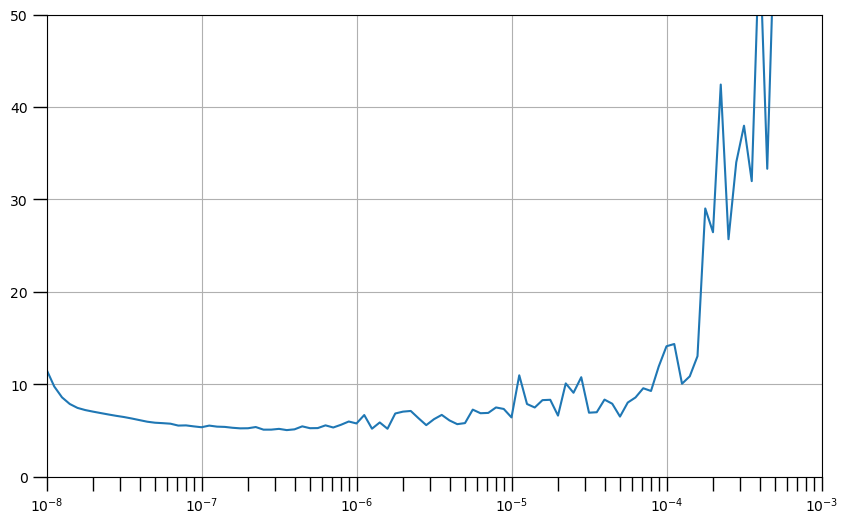

In [18]:
lrs=1e-8*(10**(np.arange(100)/20))
plt.figure(figsize=(10,6))
plt.grid(True)
plt.semilogx(lrs,history.history['loss'])
plt.tick_params('both',length=10,width=1,which='both')
plt.axis([1e-8,1e-3,0,50])

In [39]:
tf.keras.backend.clear_session()
model.set_weights(init_weights)

In [40]:
learning_rate=1e-7
optimizer=tf.keras.optimizers.SGD(momentum=0.9,learning_rate=learning_rate)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [41]:
history=model.fit(train_set,epochs=500)

Epoch 1/500
62/62 [==============================] - 3s 11ms/step - loss: 8.8307 - mae: 9.3118
Epoch 2/500
62/62 [==============================] - 1s 8ms/step - loss: 6.7519 - mae: 7.2370
Epoch 3/500
62/62 [==============================] - 1s 8ms/step - loss: 6.4980 - mae: 6.9809
Epoch 4/500
62/62 [==============================] - 1s 8ms/step - loss: 6.0124 - mae: 6.4955
Epoch 5/500
62/62 [==============================] - 1s 8ms/step - loss: 5.7209 - mae: 6.2038
Epoch 6/500
62/62 [==============================] - 1s 8ms/step - loss: 5.6428 - mae: 6.1241
Epoch 7/500
62/62 [==============================] - 1s 8ms/step - loss: 5.5627 - mae: 6.0412
Epoch 8/500
62/62 [==============================] - 1s 8ms/step - loss: 5.5202 - mae: 6.0003
Epoch 9/500
62/62 [==============================] - 1s 8ms/step - loss: 5.4721 - mae: 5.9537
Epoch 10/500
62/62 [==============================] - 1s 9ms/step - loss: 5.4180 - mae: 5.8986
Epoch 11/500
62/62 [==============================] - 1s 8

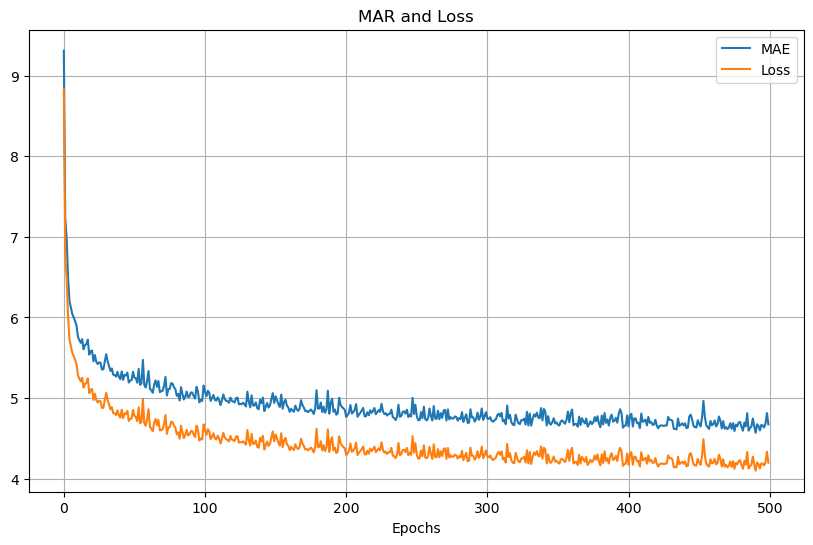

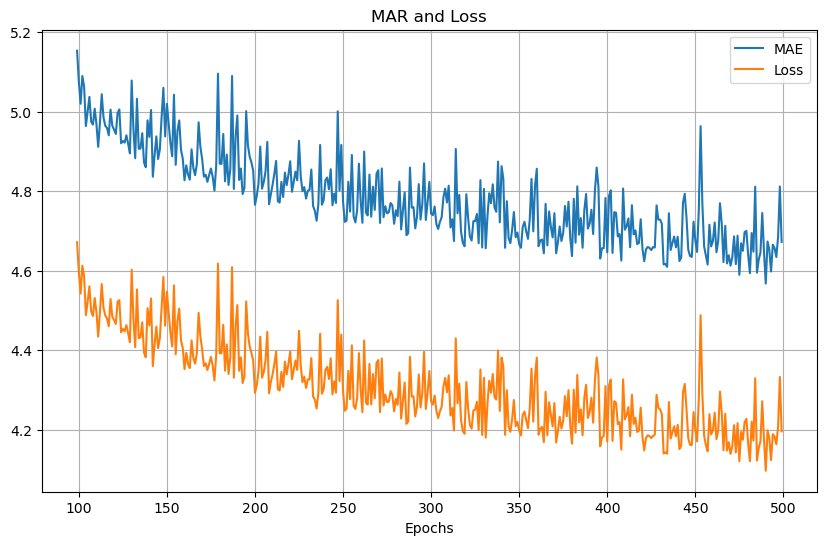

In [42]:
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss))

plot_series(time=epochs,series=(mae,loss),title='MAR and Loss',xlabel='Epochs',legend=['MAE','Loss'])

zoom_split=int(epochs[-1]*0.2)
epochs_zoom=epochs[zoom_split:]
mae_zoom=mae[zoom_split:]
loss_zoom=loss[zoom_split:]

plot_series(time=epochs_zoom,series=(mae_zoom,loss_zoom),title='MAR and Loss',xlabel='Epochs',legend=['MAE','Loss'])

# forecasting

In [43]:
def model_forecast(model,series,window_size,batch_size):
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size,shift=1,drop_remainder=True)
    dataset=dataset.flat_map(lambda w:w.batch(window_size))
    dataset=dataset.batch(batch_size).prefetch(1)
    forecast=model.predict(dataset)
    return forecast

29/29 [==============================] - 1s 9ms/step


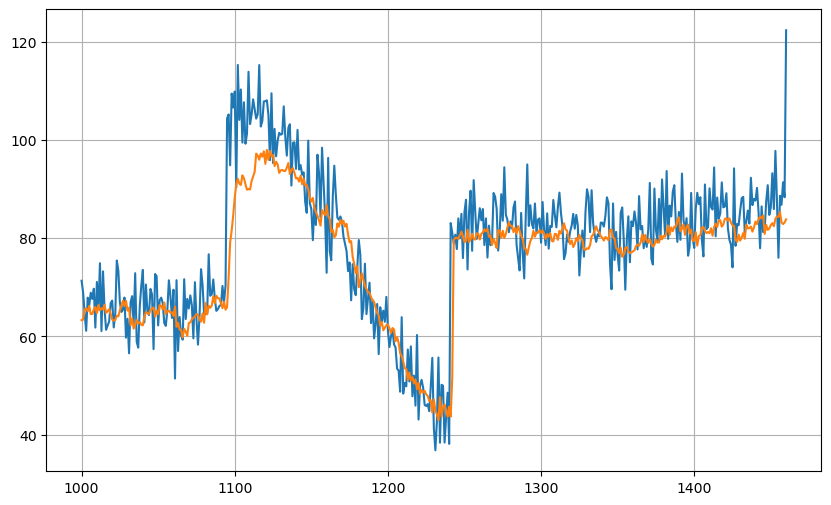

In [44]:
forecast_series=series[split_time-window_size:-1]
forecast=model_forecast(model,forecast_series,window_size,batch_size)
results=forecast.squeeze()
plot_series(time_valid,(x_valid,results))

In [38]:

print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

58.02415
5.5076785


# call back for early stopping 

In [45]:
val_set=windowed_dataset(x_valid,window_size,batch_size,shuffle_buffer_size)

In [46]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('val_mae')<5.2):
            print('\nRequired val MAE is met so cancelling training!')
            self.model.stop_training=True

callbacks=myCallback()

In [49]:
learning_rate = 4e-8

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set, epochs=500, validation_data=val_set, callbacks=[callbacks])

Epoch 1/500
62/62 [==============================] - 4s 28ms/step - loss: 4.1006 - mae: 4.5735 - val_loss: 4.7996 - val_mae: 5.2746
Epoch 2/500
62/62 [==============================] - 1s 11ms/step - loss: 4.1024 - mae: 4.5763 - val_loss: 5.0641 - val_mae: 5.5459
Epoch 3/500
62/62 [==============================] - 1s 11ms/step - loss: 4.1113 - mae: 4.5849 - val_loss: 4.9824 - val_mae: 5.4611
Epoch 4/500
62/62 [==============================] - 1s 10ms/step - loss: 4.1117 - mae: 4.5858 - val_loss: 4.8102 - val_mae: 5.2862
Epoch 5/500
62/62 [==============================] - 1s 10ms/step - loss: 4.0824 - mae: 4.5542 - val_loss: 5.1574 - val_mae: 5.6404
Epoch 6/500
62/62 [==============================] - 1s 10ms/step - loss: 4.0790 - mae: 4.5541 - val_loss: 4.8424 - val_mae: 5.3186
Epoch 7/500
62/62 [==============================] - 1s 10ms/step - loss: 4.0874 - mae: 4.5588 - val_loss: 5.0332 - val_mae: 5.5142
Epoch 8/500
62/62 [==============================] - 1s 10ms/step - loss: 4.

29/29 [==============================] - 1s 8ms/step


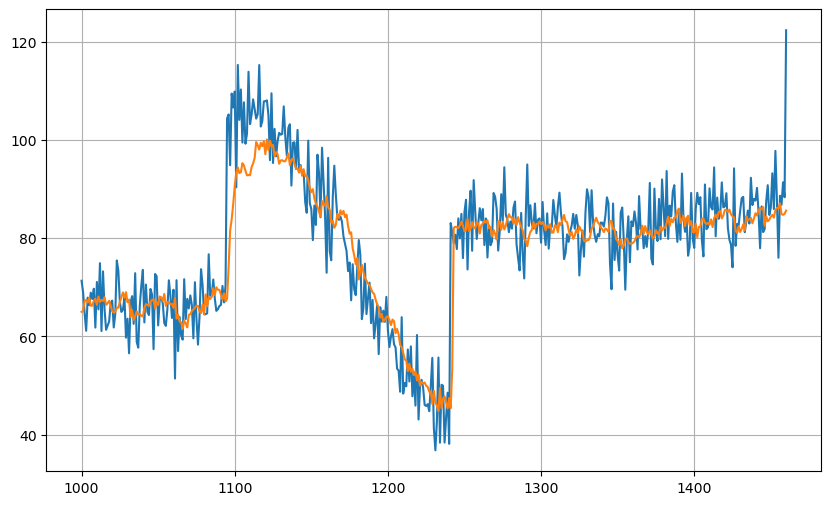

In [51]:
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [52]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

50.251575
5.138931
